#### using the scoring math from reefscape utils
#### 20250215 CJH

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, clear_output
from importlib import reload 
import reefscape_utils as ru

In [6]:
reload (ru)

<module 'reefscape_utils' from 'C:\\CJH\\Python\\FRC\\2025\\resources\\plots\\reefscape_utils.py'>

#### making trajectory guidelines - looks like we should come up one inch on the elevator as we continue down another 10 degrees

In [24]:
data = {}
for bottom in range(6,1,-1):
    engagement_positions = {key: ru.solve_engagement(val["height"], val["x"], val["offset"], bottom) for key, val in ru.target_pipes.items()}
    data[bottom]= engagement_positions
df = pd.DataFrame(data).transpose()

In [27]:
df['DEPTH'] = df.index
df = df[['DEPTH', 'H4', 'H3', 'H2', 'H1']]
df

,DEPTH,H4,H3,H2,H1
6,6,"{'H': 57.16, 'THETA': 47.25, 'offset': -2}","{'H': 29.99, 'THETA': 53.72, 'offset': 0}","{'H': 14.09, 'THETA': 53.72, 'offset': 0}","{'H': 7.1, 'THETA': 37.41, 'offset': 0}"
5,5,"{'H': 57.53, 'THETA': 44.43, 'offset': -2}","{'H': 30.32, 'THETA': 51.04, 'offset': 0}","{'H': 14.42, 'THETA': 51.04, 'offset': 0}","{'H': 7.62, 'THETA': 34.22, 'offset': 0}"
4,4,"{'H': 57.85, 'THETA': 41.67, 'offset': -2}","{'H': 30.59, 'THETA': 48.41, 'offset': 0}","{'H': 14.69, 'THETA': 48.41, 'offset': 0}","{'H': 8.07, 'THETA': 31.15, 'offset': 0}"
3,3,"{'H': 58.1, 'THETA': 39.01, 'offset': -2}","{'H': 30.8, 'THETA': 45.85, 'offset': 0}","{'H': 14.9, 'THETA': 45.85, 'offset': 0}","{'H': 8.43, 'THETA': 28.21, 'offset': 0}"
2,2,"{'H': 58.28, 'THETA': 36.45, 'offset': -2}","{'H': 30.96, 'THETA': 43.37, 'offset': 0}","{'H': 15.06, 'THETA': 43.37, 'offset': 0}","{'H': 8.7, 'THETA': 25.44, 'offset': 0}"


#### setting up the plot - lots of matplotlib

#### defining plots and animations

#### using the plots

#### play with a trajectory

In [28]:
import wpimath.controller

In [39]:
t = wpimath.controller.ElevatorFeedforward(
                kS=0,
                kG=.44,
                kV=12.05,
                kA=.1,
                dt=0.02)

In [45]:
x = [i/10 for i in range(121)]
y = [t.calculate(i) for i in x]

In [63]:
t.calculate?

Docstring:
calculate(*args, **kwargs)
Overloaded function.

1. calculate(self: wpimath._controls._controls.controller.ElevatorFeedforward, currentVelocity: wpimath.units.meters_per_second) -> wpimath.units.volts

Calculates the feedforward from the gains and setpoint assuming discrete
control. Use this method when the setpoint does not change.

:param currentVelocity: The velocity setpoint.

:returns: The computed feedforward, in volts.

2. calculate(self: wpimath._controls._controls.controller.ElevatorFeedforward, currentVelocity: wpimath.units.meters_per_second, nextVelocity: wpimath.units.meters_per_second) -> wpimath.units.volts

Calculates the feedforward from the gains and setpoints assuming discrete
control.

Note this method is inaccurate when the velocity crosses 0.

:param currentVelocity: The current velocity setpoint.
:param nextVelocity:    The next velocity setpoint.

:returns: The computed feedforward, in volts.
Type:      method

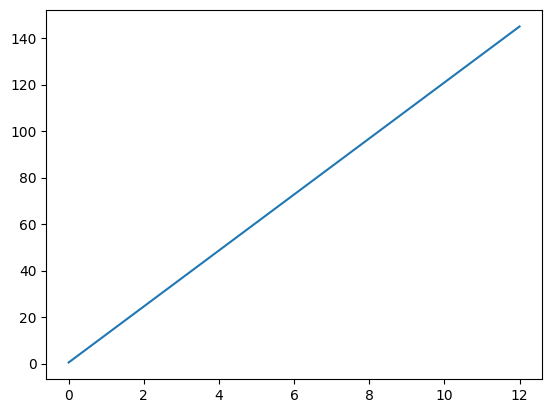

In [46]:
fig,ax = plt.subplots(1,1)
ax.plot(x,y)

In [57]:
max_rps = 5676/60
max_rps

94.6

In [59]:
geared_rps = max_rps / 15
geared_rps

6.306666666666667

In [61]:
spool = 1.91 * 3.14
spool

5.9974

In [62]:
spool * geared_rps

37.823602666666666